In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    CIL contributors 

# CIL Preconditioner and step size methods demonstration 
This notebook runs on CIL Master (built on 20/06/2024) and demonstrates the new callback functionality 

In [2]:
from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer
import numpy as np
import matplotlib.pyplot as plt 
from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import GD
from cil.optimisation.functions import LeastSquares, L2NormSquared
from cil.optimisation.operators import MatrixOperator
from cil.optimisation.utilities import callbacks, StepSizeMethods, preconditioner
from cil.framework import  VectorData,


# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'



/home/bih17925/miniconda3/envs/cil_testing2/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



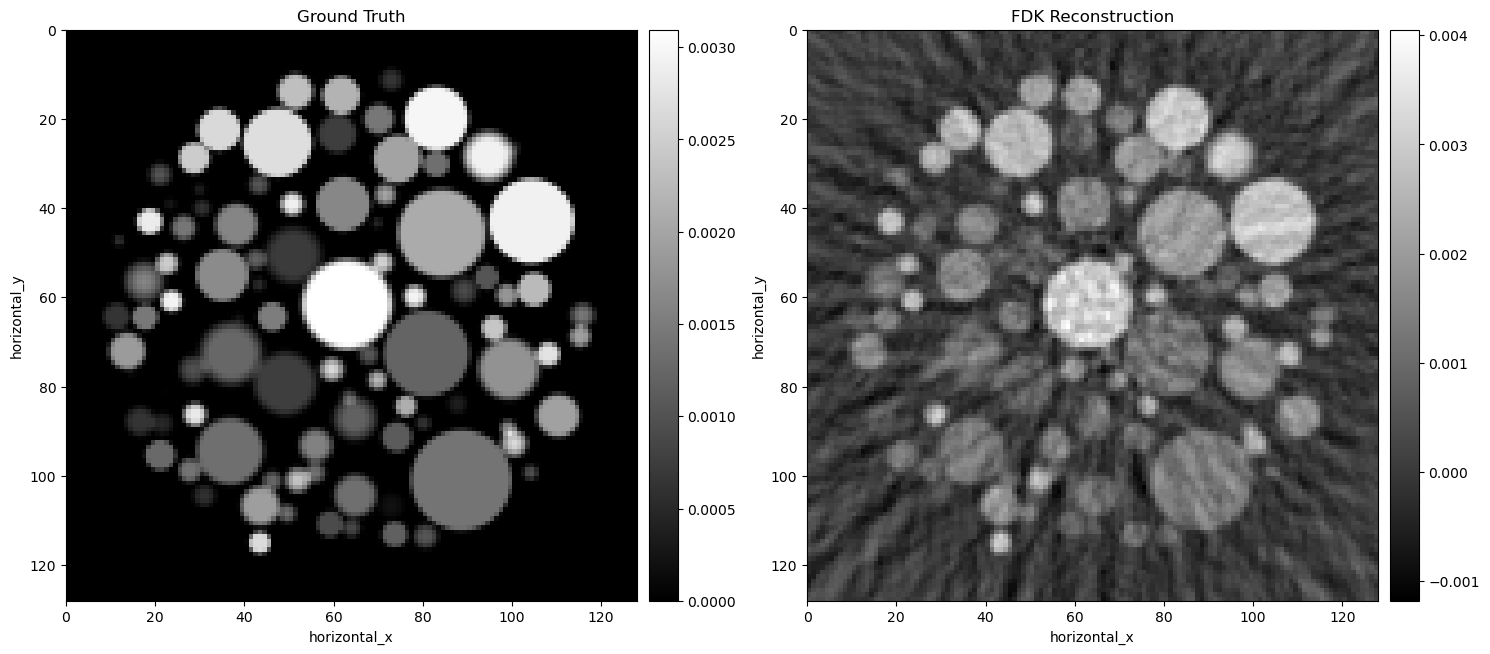

In [3]:

#%% Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
twoD = True
if twoD:
    data = data.get_slice(vertical='centre')
    ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

#%%
recon = FDK(absorption, image_geometry=ig).run()
#%%
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)

# %%


## Gradient descent with fixed step size 

  0%|          | 0/50 [00:00<?, ?it/s]

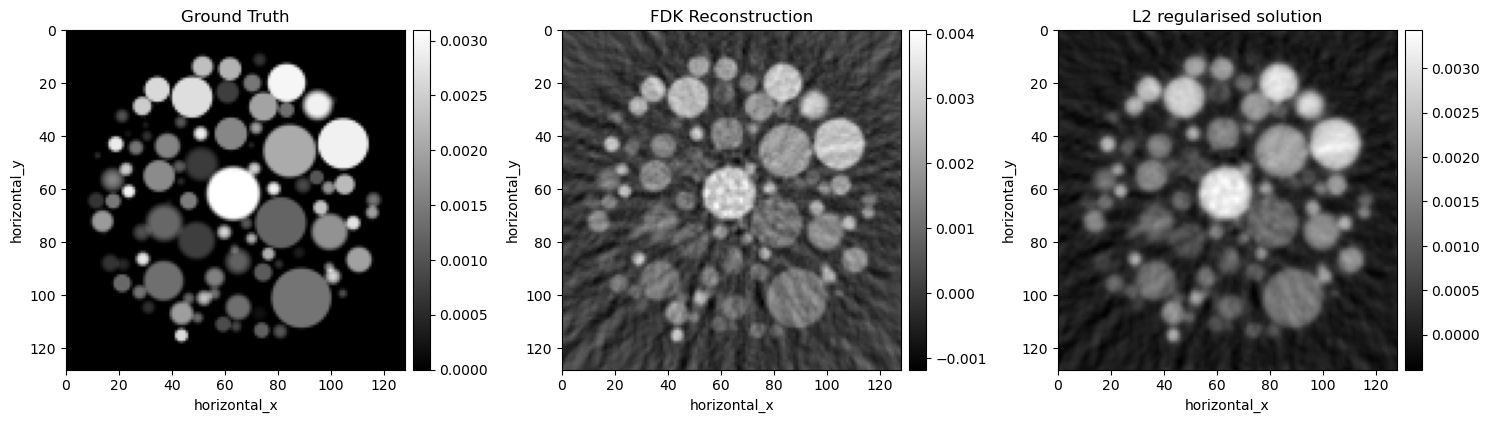

In [4]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo=GD(initial=ig.allocate(0), objective_function=F, step_size=1/F.L )
algo.run(50)
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3)


Text(0, 0.5, 'Objective value')

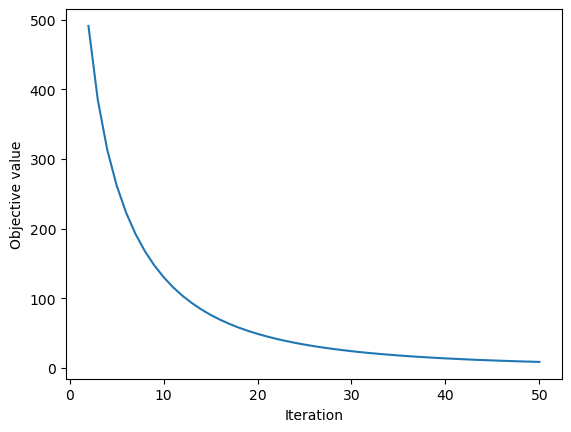

In [5]:
plt.plot(range(2,51),algo.objective[2:])
plt.xlabel('Iteration')
plt.ylabel('Objective value')

## Gradient descent default behaviour 


In [6]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_default=GD(initial=ig.allocate(0), objective_function=F )
algo_default.run(50)
show2D([ground_truth, recon, algo_default.solution], title = ['Ground Truth', 'FDK Reconstruction', 'Tik solution'], origin = 'upper', num_cols = 3)


  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Could not find a proper step_size in 40.0 loops. Consider increasing alpha or max_iterations.

This does not work because in 40 iterations, the Armijio step size rule as not found a suitable step size. We can alter the number of iterations in the step size rule to allow it to run without error: 

  0%|          | 0/50 [00:00<?, ?it/s]

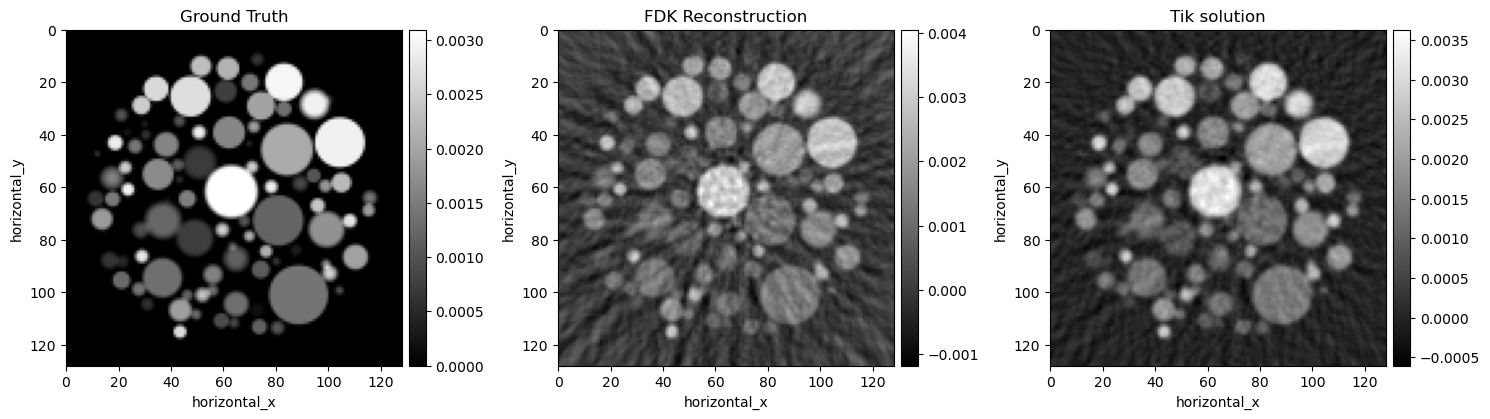

In [7]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_armijio=GD(initial=ig.allocate(0), objective_function=F, step_size=StepSizeMethods.ArmijoStepSizeRule(max_iterations=50))
algo_armijio.run(50)
show2D([ground_truth, recon, algo_armijio.solution], title = ['Ground Truth', 'FDK Reconstruction', 'Tik solution'], origin = 'upper', num_cols = 3)


Text(0, 0.5, 'Objective value')

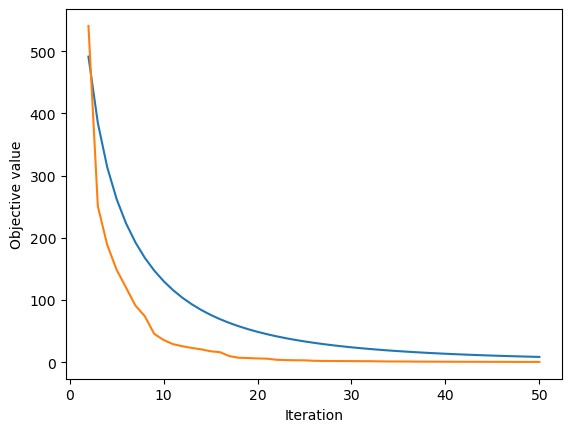

In [8]:
plt.plot(range(2,51),algo.objective[2:], label='step_size=1/F.L')
plt.plot(range(2,51),algo_armijio.objective[2:], label='Armijio rule')

plt.xlabel('Iteration')
plt.ylabel('Objective value')

## Gradient descent custom step size rule 

  0%|          | 0/50 [00:00<?, ?it/s]

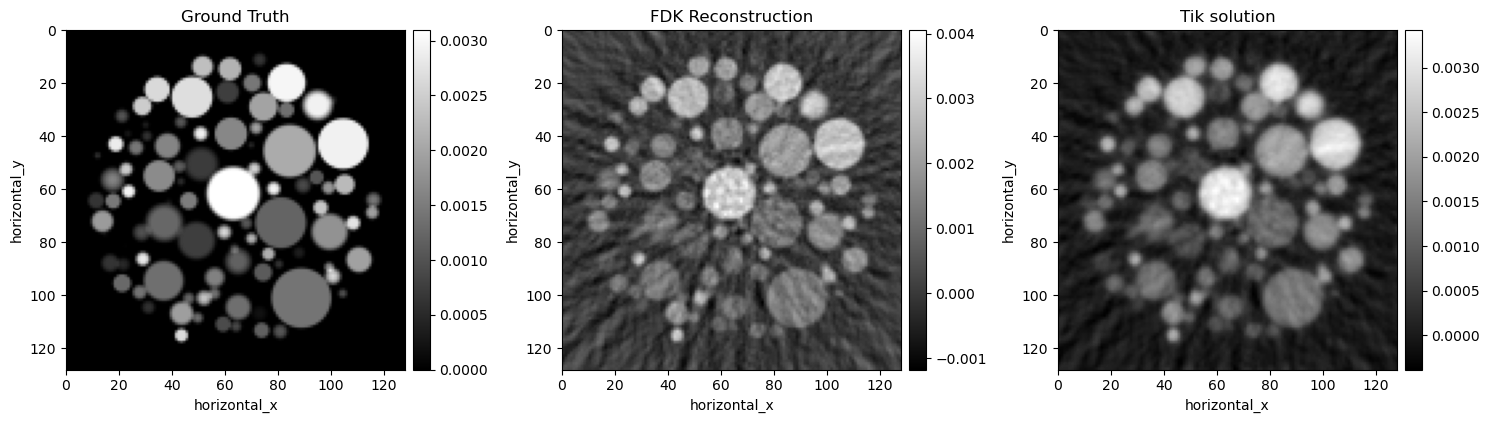

In [9]:
class shrinking_step_size(StepSizeMethods.StepSizeRule):
    def __init__(self, initial=0.1, shrinkage=0.999):
        self.shrinkage=shrinkage
        self.initial=initial
    
    def get_step_size(self, algorithm):
        return self.initial*self.shrinkage**algorithm.iteration
    
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_custom=GD(initial=ig.allocate(0), objective_function=F, step_size=shrinking_step_size(initial=1/F.L) )
algo_custom.run(50)
show2D([ground_truth, recon, algo_custom.solution], title = ['Ground Truth', 'FDK Reconstruction', 'Tik solution'], origin = 'upper', num_cols = 3)


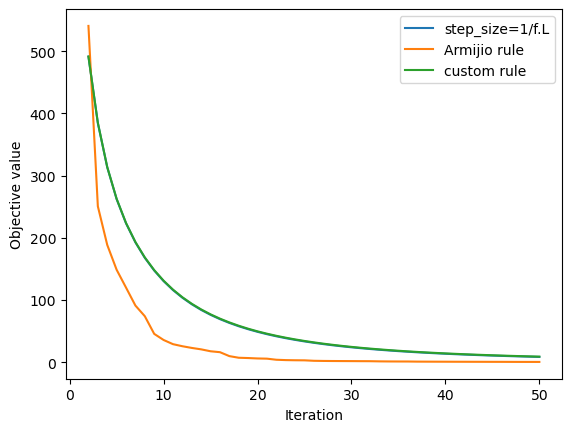

In [10]:
plt.plot(range(2,51),algo.objective[2:], label='step_size=1/f.L')
plt.plot(range(2,51),algo_armijio.objective[2:], label='Armijio rule')
plt.plot(range(2,51),algo_custom.objective[2:], label='custom rule')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()

# Preconditioners 

Consider $b=(0,0)^T$, $A=\begin{pmatrix}
1 & 0.3 \\
0 & 0.1 
\end{pmatrix}$ , we can visualise the minimisation problem to find $x^*$ such that $Ax^*=y$.


In [11]:
def f(x,y):
    return np.linalg.norm(np.matmul(np.array([[1,0.3],[0, 0.1]]), np.array([x,y]))-np.array([0,0]))
    

Text(0, 0.5, 'y1')

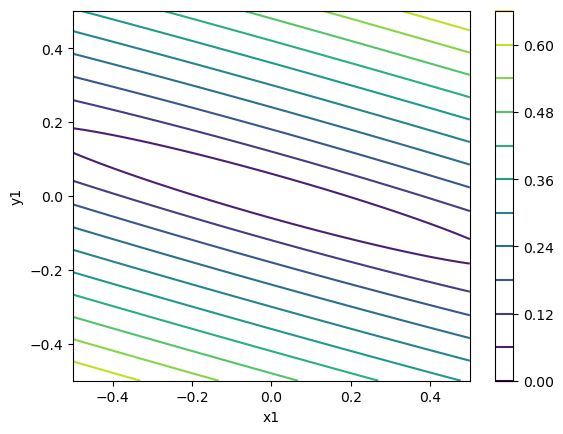

In [12]:

plt.figure()

x_ = np.linspace(-0.5, 0.5, num=200)
y_ = np.linspace(-0.5, 0.5, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(x_[i],y_[j])

c = plt.contour(x, y, levels, 10)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('y1')

We precondition by the sensitivity of the matrix $A$ given by a vector $1/(A^T \mathbf{1})$

In [13]:
precon=preconditioner.Sensitivity(operator=MatrixOperator(np.array([[1,0.3],[0.01, 0.1]])))


Text(0, 0.5, 'y1')

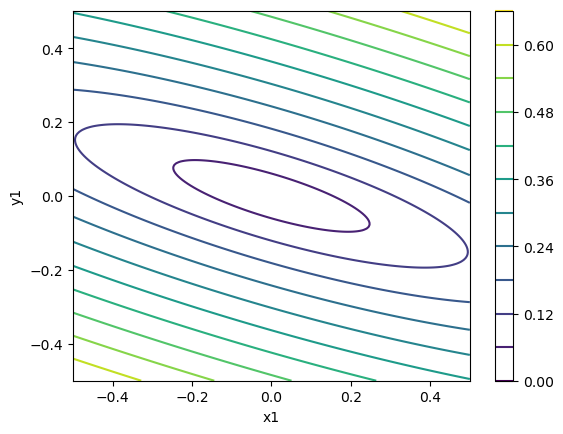

In [14]:
def f(x,y):
    return np.linalg.norm(precon.array.as_array()*(np.matmul(np.array([[1,0.3],[0.01, 0.1]]), np.array([x,y]))-np.array([0,0])))
plt.figure()

x_ = np.linspace(-0.5, 0.5, num=200)
y_ = np.linspace(-0.5, 0.5, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(x_[i],y_[j])

c = plt.contour(x, y, levels, 10)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('y1')

In [15]:
alpha=0.1
A = MatrixOperator(np.array([[1.,0.3],[0.01, 0.1]]))
b=VectorData(np.array([0.,0.]))

F = 0.5*LeastSquares(A = A, b = b)

algo=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, step_size=1/F.L)
algo.run(300)

algo_precon=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, preconditioner=preconditioner.Sensitivity(operator=A), step_size=1/F.L)
algo_precon.run(300)



  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [16]:
algo_precon.solution.as_array()

array([-0.0012519 ,  0.00407944])

In [17]:
algo.solution.as_array()

array([-0.0257575 ,  0.08484398])

The preconditioned gradient descent converges quicker:

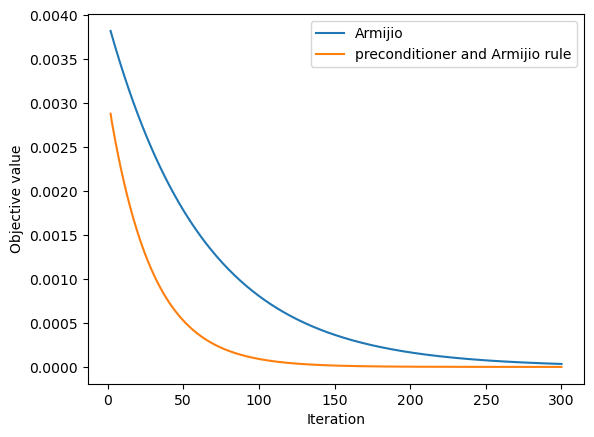

In [18]:
plt.plot(range(2,301),algo.objective[2:], label='Armijio')
plt.plot(range(2,301),algo_precon.objective[2:], label='preconditioner and Armijio rule')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()

Using a callback, we can see the progress of the algorithm and we see that the initial steps of the preconditioned algorithm get is much closer than in the unconditioned case. 

In [19]:
class save_solutions(callbacks.Callback):
    def __init__(self):
        self.solutions=[np.array([0.,1.])]
    
    def __call__(self, algorithm):
        self.solutions.append(algorithm.solution.as_array().copy())
        
callback_no_precon=save_solutions()
algo=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, step_size=1/F.L)
algo.run(300,callbacks=[callback_no_precon])


callback_precon=save_solutions()
algo_precon=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, preconditioner=preconditioner.Sensitivity(operator=A), step_size=1/F.L)
algo.run(300,callbacks=[callback_precon])


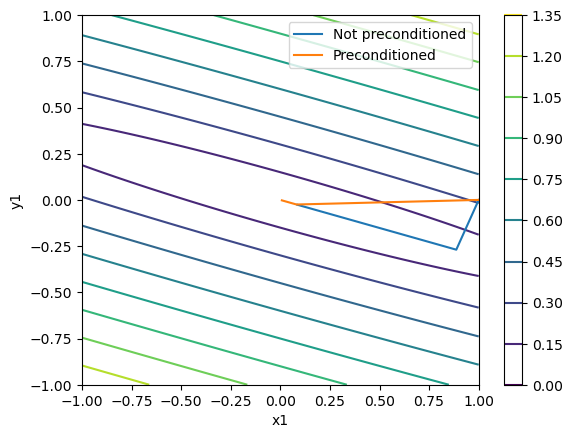

In [20]:
def f(x,y):
    return np.linalg.norm(np.matmul(np.array([[1,0.3],[0, 0.1]]), np.array([x,y]))-np.array([0,0]))

plt.figure()

x_ = np.linspace(-1, 1, num=200)
y_ = np.linspace(-1, 1, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(x_[i],y_[j])

c = plt.contour(x, y, levels, 10)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('y1')



plt.plot(np.array(callback_no_precon.solutions)[::5,1], np.array(callback_no_precon.solutions)[::5,0], label='Not preconditioned')
plt.plot(np.array(callback_precon.solutions)[::5,1], np.array(callback_precon.solutions)[::5,0], label='Preconditioned')
plt.legend()

In [21]:
#TODO: Can we go on to explain this in terms of length of rays in the CT case?? What does preconditioned by sensitivity mean for CT? 